### Аналитика простоев и неэффективности использования вагонного парка

Компания управляет вагонным парком и сталкивается с избыточным простоем вагонов
на станции дислокации, что снижает операционную эффективность использования
подвижного состава.

Цель анализа — выявить факторы, ассоциированные с критическим простоем вагонов
на станции дислокации, и определить сегменты вагонного парка и инфраструктуры,
в которых концентрация таких простоев наиболее высока.

Ключевой аналитический вопрос:  
**при каких условиях и в каких сегментах вагонного парка возникает повышенный риск
критического простоя вагонов на станции дислокации?**

Объект анализа: вагоны вагонного парка (операционный срез состояния).  
Целевая метрика: простой вагона на станции дислокации (в днях).  
Критический простой: простой более 10 суток.

Простой на станции ремонта анализируется отдельно и не является основной
метрикой проекта. Финансовые потери и оборот не оцениваются в рамках данного
анализа в связи с отсутствием соответствующих данных.

Данные представляют собой срез текущего состояния вагонов без времовой
динамики, что накладывает ограничения на интерпретацию результатов.


#### данные = срез состояния вагонов
#### цель = выявление факторов повышенного простоя

## Проверяемые гипотезы

**Гипотеза 1 (инфраструктурная):**  
Доля вагонов с критическим простоем различается между дорогами дислокации.

**Гипотеза 2 (операционная):**  
Операционное состояние вагона связано с вероятностью критического простоя.

**Гипотеза 3 (техническая):**  
Наличие зарегистрированной неисправности вагона увеличивает вероятность
критического простоя.


In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np

In [35]:
df = pd.read_excel('/Users/elenatsoi/Desktop/A:B тесты /портфолио /vagons.xlsx')
df.isna().sum()

Номер вагона                           0
Государство, текущей дислокации        0
Дорога дислокации                      0
Станция текущей дислокации             0
Дорога отправления, наименование       0
Станция отправления                    0
Дорога назначения                      0
Станция назначения                     0
Тип вагона                             0
Груж\Порож                             0
Груз                                   4
Дата отправления                       0
Дата следующего планового ремонта      0
Состояние вагона                       0
Простой на станции ремонта (дни)     400
Простой на станции дислокации          0
Остаточный пробег                     11
Депо забраковки ВУ-23                  6
Неисправность текущая                413
dtype: int64

In [36]:
df.dtypes

Номер вагона                                  int64
Государство, текущей дислокации              object
Дорога дислокации                            object
Станция текущей дислокации                   object
Дорога отправления, наименование             object
Станция отправления                          object
Дорога назначения                            object
Станция назначения                           object
Тип вагона                                   object
Груж\Порож                                   object
Груз                                         object
Дата отправления                     datetime64[ns]
Дата следующего планового ремонта    datetime64[ns]
Состояние вагона                             object
Простой на станции ремонта (дни)            float64
Простой на станции дислокации               float64
Остаточный пробег                           float64
Депо забраковки ВУ-23                        object
Неисправность текущая                        object
dtype: objec

In [37]:
df['Номер вагона'].duplicated().sum()


np.int64(0)

In [38]:
df['Номер вагона'].is_unique

True

In [39]:
df.shape

(425, 19)

In [40]:
df. describe()


,Номер вагона,Дата отправления,Дата следующего планового ремонта,Простой на станции ремонта (дни),Простой на станции дислокации,Остаточный пробег
count,4.250000e+02,425,425,25.000000,425.000000,414.000000
mean,3.961551e+07,2025-12-01 09:32:36.705882368,2027-02-17 18:48:16.941176320,25.708400,13.561153,95814.164251
min,2.800220e+07,2025-06-10 00:00:00,2025-12-14 00:00:00,0.990000,0.000000,12246.000000
25%,2.805324e+07,2025-11-26 00:00:00,2026-07-24 00:00:00,4.520000,1.080000,74844.500000
50%,2.880630e+07,2025-12-09 00:00:00,2027-01-22 00:00:00,14.710000,4.830000,96465.000000
75%,6.068291e+07,2025-12-15 00:00:00,2027-09-20 00:00:00,30.980000,17.380000,119216.750000
max,6.781503e+07,2025-12-22 00:00:00,2028-11-12 00:00:00,164.020000,188.790000,158150.000000
std,1.578089e+07,NaN,NaN,36.179889,22.293759,29503.461183


In [41]:
df['Простой на станции ремонта (дни)']=df['Простой на станции ремонта (дни)'].fillna(0)
df['has_defect'] = df['Неисправность текущая'].notna()
df.head(5)

,Номер вагона,"Государство, текущей дислокации",Дорога дислокации,Станция текущей дислокации,"Дорога отправления, наименование",Станция отправления,Дорога назначения,Станция назначения,Тип вагона,Груж\Порож,Груз,Дата отправления,Дата следующего планового ремонта,Состояние вагона,Простой на станции ремонта (дни),Простой на станции дислокации,Остаточный пробег,Депо забраковки ВУ-23,Неисправность текущая,has_defect
0,28005239,РЖД,ЮУР,Карталы I,ЮУР,Нижнеувельская,ЮУР,Тамерлан,КР,ПОР,ВАГОНЫ ЖД СВ,2025-12-18,2026-02-12,Порожний ход,0.0,0.33,76668.0,"ВЧДЭ-6 Инская ОАО ""РЖД""",NaN,False
1,28007268,РЖД,ЮУР,Нижнеувельская,СКВ,Полтавская,ЮУР,Нижнеувельская,КР,ПОР,,2025-12-09,2026-01-22,Под выгрузкой,0.0,6.08,58598.0,"ВЧДр Чеpняховск ОАО ""РЖД""",NaN,False
2,28023646,РЖД,ЮУР,Тамерлан,ЮУР,Пирит,ЮУР,Тамерлан,КР,ПОР,,2025-12-08,2027-01-10,Под погрузкой,0.0,11.63,69393.0,"ВЧДЭ-7 Белогорск ОАО ""РЖД""",NaN,False
3,28039402,РЖД,ЮУР,Пирит,ЮУР,Нижнеувельская,ЮУР,Пирит,КР,ПОР,ВАГОНЫ ЖД СВ,2025-12-17,2027-05-11,Под погрузкой,0.0,2.83,109381.0,ВЧД-8 Астана,NaN,False
4,28052371,РЖД,ЮУР,Кропачево,ПРВ,Покровск-приволжский,ЗСБ,Томск II,КР,ГРУЖ,ПОЛИПРОПИЛЕН,2025-12-16,2026-07-24,Гружёный ход,0.0,1.04,71493.0,ВЧД-19 Костанай,NaN,False


In [42]:
df['critical_idle'] = df['Простой на станции дислокации'] > 5
df['critical_idle'].value_counts(normalize=True)


critical_idle
False    0.505882
True     0.494118
Name: proportion, dtype: float64

In [43]:
# Проверка## Гипотеза 1. Различия по дорогам дислокации
risk_by_road = (
    df.groupby('Дорога дислокации')['critical_idle']
      .agg(['count', 'mean']).reset_index()
      .rename(columns={'mean': 'critical_idle_rate'})
      .sort_values('critical_idle_rate', ascending=False)
)
risk_by_road = risk_by_road[risk_by_road['count'] >= 10]
risk_by_road.head(5)

,Дорога дислокации,count,critical_idle_rate
9,КРС,17,0.882353
15,СЕВ,27,0.814815
13,ПРВ,28,0.607143
19,ЮВС,17,0.588235
11,МСК,17,0.588235


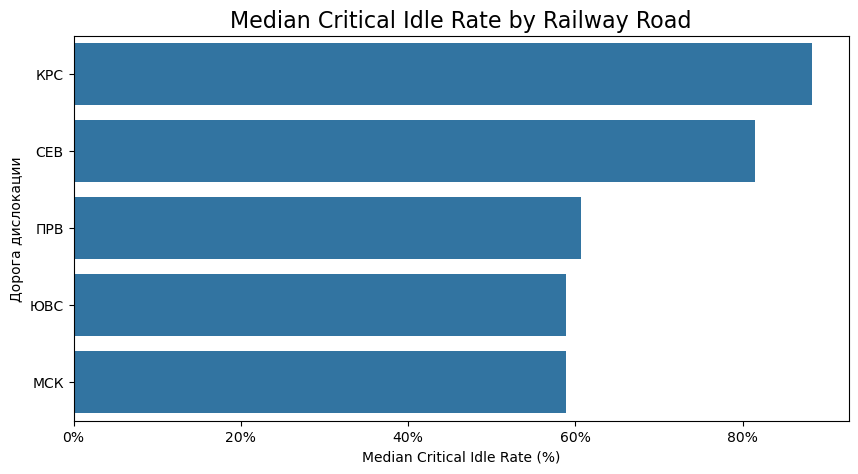

In [58]:
### Hypothesis 1  Certain railway roads concentrate a higher share of critical wagon idle time.

sns.barplot(
    data=top5,
    y='Дорога дислокации',
    x='critical_idle_rate',
    estimator=np.median,
    errorbar=None)
plt.gca().xaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
plt.xlabel('Median Critical Idle Rate (%)')
plt.title('Median Critical Idle Rate by Railway Road', fontsize=16)

plt.show()
# Roads KPC and CEB show median critical idle rates above 80%,
# indicating concentration of operational delays.
# Limited sample size per road requires cautious interpretation.

**Вывод:**  
На дорогах КРС и СЕВ наблюдается наибольшая медианная доля вагонов с критическим простоем (выше 80%), что указывает на концентрацию операционных задержек на отдельных участках инфраструктуры.

**Интерпретация:**  
Полученный результат позволяет рассматривать данные дороги как приоритетные зоны для детального операционного анализа и поиска узких мест.

**Ограничение:**  
Размер выборки по отдельным дорогам ограничен, что требует осторожности при интерпретации различий.


#### Проверка Гипотеза 2. Различия по дорогам дислокации
Доля вагонов  под погрузкой с критическим простоем и в ремонте около 80%, что указывает на концентрацию операционных задержек 
в данных сегментах инфраструктуры. При этом размер выборки по каждой дороге ограничен, что требует осторожной интерпретации результатов.
Статус «ремонт» отражает технический контур и частично пересекается с процессом простоя, поэтому результаты по данной категории интерпретируются ограниченно и используются преимущественно для описательного сравнения.

In [59]:
risk_by_status = (
    df.groupby('Состояние вагона')['critical_idle']
      .agg(['count','mean']).reset_index()
      .rename(columns={'mean':'critical_idle_rate'})
      .query('count >= 10')
      .sort_values('critical_idle_rate', ascending=False))

risk_by_status


,Состояние вагона,count,critical_idle_rate
3,Под погрузкой,99,0.808081
5,Ремонт,29,0.793103
2,Под выгрузкой,152,0.572368
4,Порожний ход,34,0.147059
0,Гружёный ход,109,0.128440


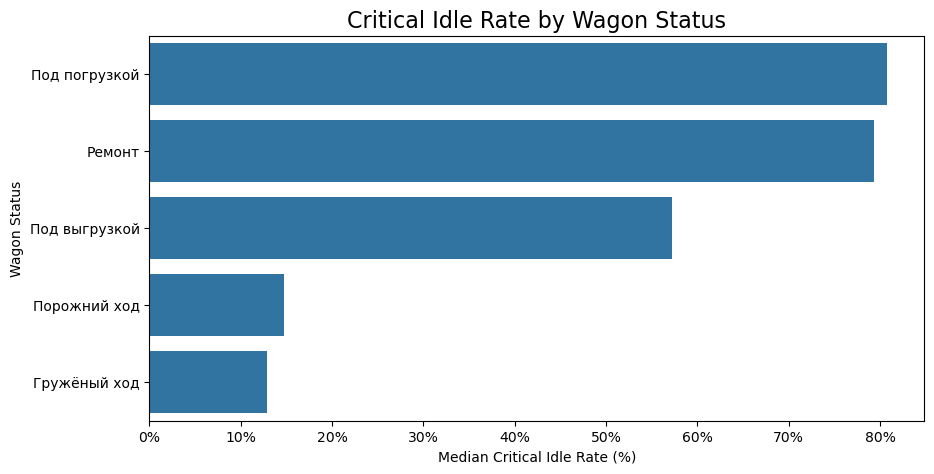

In [63]:
### Hypothesis 2  Critical idle rate varies significantly depending on wagon operational status.

sns.barplot(
    data=risk_by_status,
    y='Состояние вагона',
    x='critical_idle_rate',
    estimator=np.median,
    errorbar=None)
plt.gca().xaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, _: f'{x:.0%}'))

plt.title('Critical Idle Rate by Wagon Status', fontsize=16)
plt.xlabel('Median Critical Idle Rate (%)')
plt.ylabel('Wagon Status')

plt.show()

**Вывод:**  
Медианная доля критического простоя существенно различается в зависимости от операционного состояния вагона. Наибольшие значения наблюдаются для вагонов, находящихся под погрузкой и в ремонте.

**Интерпретация:**  
Результат указывает на то, что критический простой в большей степени связан с внутренними операционными процессами, а не с движением вагонов по сети.

**Практический вывод:**  
Оптимизация процессов погрузки и ремонта потенциально может дать наибольший эффект в снижении критического простоя.


#### Гипотеза 3. Текущая неисправность

Гипотеза не подтвердилась. В рамках данного датасета фактор текущей неисправности не демонстрирует связи с критическим простоем, что связано с крайне малым числом наблюдений.


In [66]:
risk_by_defect = (
    df.groupby('has_defect')['critical_idle']
      .agg(['count','mean']).reset_index()
      .rename(columns={'mean':'critical_idle_rate'})
)
risk_by_defect


,has_defect,count,critical_idle_rate
0,False,413,0.493947
1,True,12,0.500000


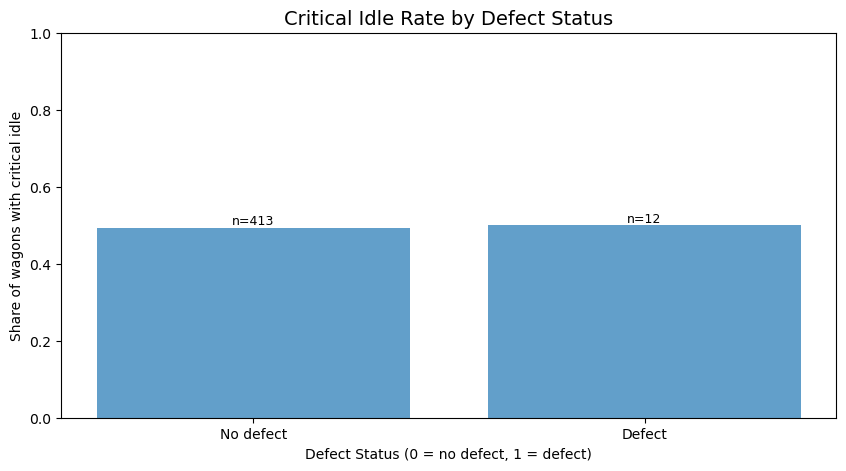

In [70]:
### Hypothesis 3  Wagons with registered defects have a higher probability of critical idle time.

bars = plt.bar(
    risk_by_defect['has_defect'],
    risk_by_defect['critical_idle_rate'],
    alpha=0.7)

plt.title('Critical Idle Rate by Defect Status', fontsize=14)
plt.xlabel('Defect Status (0 = no defect, 1 = defect)')
plt.ylabel('Share of wagons with critical idle')

plt.xticks([0, 1], ['No defect', 'Defect'])
plt.ylim(0,1)
# подписи n над столбцами
for bar, n in zip(bars, risk_by_defect['count']):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f'n={n}',
        ha='center',
        va='bottom',
        fontsize=9 )

plt.show()

# The observed critical idle rates are similar for wagons with and without defects.
# However, the defect group sample size (n=12) is insufficient for reliable inference.
# This hypothesis cannot be confirmed with the current data.


**Вывод:**  
Значимых различий в доле критического простоя между вагонами с зарегистрированными дефектами и без них не выявлено.

**Ограничение:**  
Численность группы вагонов с дефектами крайне мала (n = 12), что не позволяет сделать статистически надёжные выводы.

**Заключение:**  
Гипотеза о влиянии наличия дефекта вагона на вероятность критического простоя не подтверждается на имеющихся данных.


## Результаты анализа

В рамках анализа операционного среза вагонного парка был изучен критический
простой вагонов на станции дислокации. Анализ показал, что критический простой
распределён неравномерно и концентрируется в отдельных сегментах инфраструктуры
и операционных состояний вагонов.

| Фактор                    | Результат анализа                                                   | Статус          |
|---------------------------|---------------------------------------------------------------------|-----------------|
| Дорога дислокации         | Существенные различия, выявлены зоны концентрации риска              | Значим          |
| Операционное состояние    | Повышенный риск под погрузкой и в ремонте                            | Значим          |
| Текущая неисправность     | Связь не выявлена (крайне малая выборка)                             | Неинформативен  |


На отдельных дорогах дислокации доля вагонов с критическим простоем существенно
превышает медианный уровень по выборке, что указывает на концентрацию
операционных задержек в конкретных сегментах инфраструктуры.

Операционное состояние вагона оказывает заметное влияние на вероятность
критического простоя: вагоны, находящиеся под погрузкой и в ремонте,
демонстрируют наиболее высокий риск.

Наличие зафиксированной текущей неисправности не показало связи с критическим
простоем в рамках данного датасета, что обусловлено крайне малой численностью
соответствующей группы и не позволяет делать надёжные выводы.


Результаты анализа позволяют выделить дороги дислокации и операционные состояния
вагонов, требующие приоритетного управленческого контроля.

Фокус операционных проверок и последующего анализа причин простоев целесообразно
сместить в сторону выявленных зон повышенного риска, прежде всего процессов
погрузки и ремонта, а также отдельных инфраструктурных сегментов.


Анализ выполнен на основе среза состояния вагонов без учёта времовой динамики.
Для отдельных факторов (в частности, текущих неисправностей) размер выборки
недостаточен для статистически надёжных выводов.
